## Importing necessary Libraries 

In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split , RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


/home/tecorb/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Load Dataset

In [26]:
df = pd.read_csv('credit_risk_dataset.csv')
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


<Axes: xlabel='person_age'>

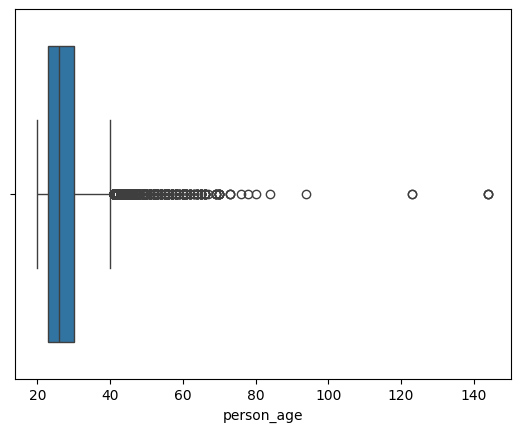

In [27]:
sns.boxplot(x=df['person_age'])

<Axes: xlabel='person_emp_length'>

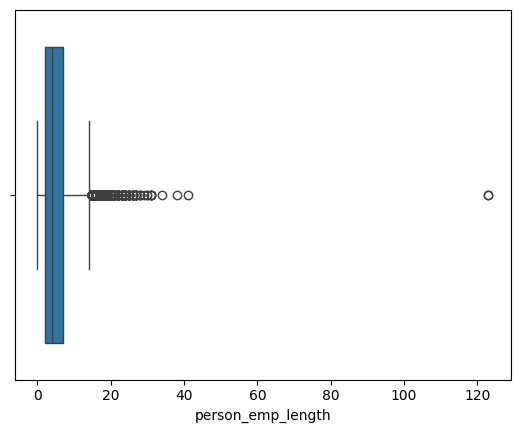

In [28]:
sns.boxplot(x=df['person_emp_length'])

In [29]:
df = df[(df['person_age']<=80)&(df['person_emp_length']<=60)]

In [30]:
len(df)

31677

### Overview of columns and Data Types 

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31677 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31677 non-null  int64  
 1   person_income               31677 non-null  int64  
 2   person_home_ownership       31677 non-null  object 
 3   person_emp_length           31677 non-null  float64
 4   loan_intent                 31677 non-null  object 
 5   loan_grade                  31677 non-null  object 
 6   loan_amnt                   31677 non-null  int64  
 7   loan_int_rate               28631 non-null  float64
 8   loan_status                 31677 non-null  int64  
 9   loan_percent_income         31677 non-null  float64
 10  cb_person_default_on_file   31677 non-null  object 
 11  cb_person_cred_hist_length  31677 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB


### Counting Null Values in EAch Columns

In [32]:
df.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3046
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

### Filling null values with "Mean"

In [33]:
df['loan_int_rate'].fillna(df['loan_int_rate'].mean(),inplace = True)

/tmp/ipykernel_16585/1365291646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_int_rate'].fillna(df['loan_int_rate'].mean(),inplace = True)


In [34]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
5,21,9900,OWN,2.0,VENTURE,A,2500,7.14,1,0.25,N,2


# Encoding the Categorical Variables 

In [35]:
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

/tmp/ipykernel_16585/2553969703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
/tmp/ipykernel_16585/2553969703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = le.fit_transform(df[col])
/tmp/ipykernel_16585/2553969703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [36]:
df.head(2)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3


### Splitting the Data in to 2 Parts 

In [37]:
X = df.drop({'cb_person_default_on_file','loan_percent_income','loan_status','person_home_ownership','loan_grade'},axis = 1)
y = df['cb_person_default_on_file']

### Used SMOTE to reduce the class Imbalance Problem

In [38]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X,y)

In [39]:
y_train_res.value_counts()

cb_person_default_on_file
0    26049
1    26049
Name: count, dtype: int64

### Splitting the Data into Train and Test Data 

In [40]:
x_train, x_test , y_train, y_test = train_test_split(X_train_res,y_train_res,test_size=0.2,random_state=42)

### Hyper Parameter Tuning 

In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0]
}

model = XGBClassifier()

search = RandomizedSearchCV(model, param_distributions=param_grid,
                            n_iter=20, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
search.fit(x_train, y_train)

print("Best Parameters:", search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1}


## Training the model on the BEst Parameters 

In [50]:
model = XGBClassifier(
    subsample=0.6,
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(x_train, y_train)



/home/tecorb/.local/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [16:51:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Evaluating the model Performance 

In [51]:
# Make predictions
y_pred = model.predict(x_test)

# Evaluate model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8876199616122841
Confusion Matrix:
 [[4519  698]
 [ 473 4730]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      5217
           1       0.87      0.91      0.89      5203

    accuracy                           0.89     10420
   macro avg       0.89      0.89      0.89     10420
weighted avg       0.89      0.89      0.89     10420



In [52]:
from sklearn.metrics import roc_auc_score

y_proba = model.predict_proba(x_test)[:, 1]
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


ROC AUC Score: 0.9685095271888488


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

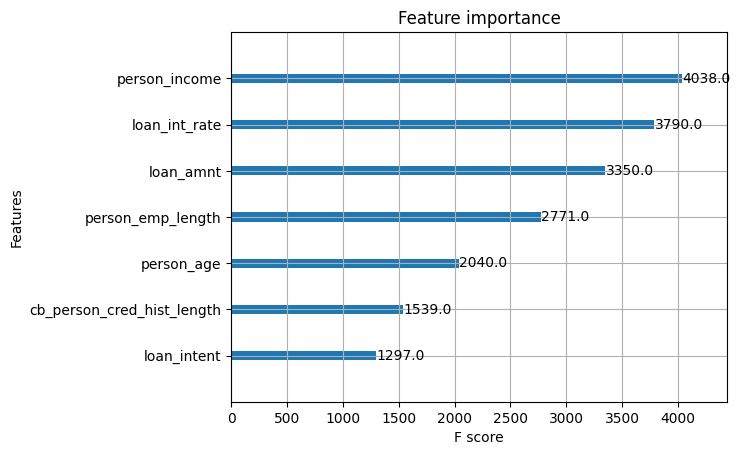

In [53]:
from xgboost import plot_importance
plot_importance(model)